# Super Resolution Generative Adversarial Network (SRGAN) of CelebA Dataset

## Introduction

This program will train a model to generate realistic high-resolution (HR) images from low-resolution (LR) images. Alternatively, you can skip the training and go straight to generation by loading the pre-trained model.

To train the model yourself:
1. Download the dataset from [here.](https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ)
2. Extract the images to `datasets/img_align_celeba/<000001.jpg,  000002.jpg,  etc.>`
3. Run all cells in the `Training` section.  (Note: on a Nvidia RTX 2080 Super GPU, training took ~15 hours for 30000 epochs.)
   
To load the pre-trained model:
1. Run all cells in the `Loading a Pre-Trained Model` section.

To generate HR images from LR images:
1. Select a .jpg image of interest – either from the dataset or your own collection, and move it into the same directory as this notebook.
2. Run all cells in the `Generation` section.

## Training

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
import keras.backend as K
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam

import datetime
import scipy
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os

Using TensorFlow backend.


In [ ]:
# Define the SRGAN class and methods.

class SRGAN():
    def __init__(self):
        """
        Class initialization.
        
        ==Input==
          N/A
        
        ==Output==
          Instantiates self parameters and builds vgg, generator, discrimator, and combined models.
        """
        
        # Input shape of images
        self.channels = 3                        # (H, W, RGB)
        self.lr_height = 64                      # LR height
        self.lr_width = 64                       # LR width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = 256                     # HR height = LR height upscaled by factor of 4
        self.hr_width = 256                      # HR width = LR width upscaled by factor of 4
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)
        
        # Number of residual blocks in the generator
        self.n_residual_blocks = 16
        
        optimizer = Adam(0.0002, 0.5)
        
        # Utilize a pre-trained VGG19 model to obtain perceptual content loss rather than pixel-wise loss.
        #    Specifically, the VGG19 model will extract image features from the original HR image and the
        #    generated HR image, and seek to minimize the mean-squared error between them.
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        
        # Utilize data_loader.py file to load in our dataset
        self.dataset_name = 'img_align_celeba'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.hr_height, self.hr_width))
        
        # Calculate output shape of discriminator (PatchGAN). This is so penalizations will only occur occur
        #    in local image patches.
        patch = int(self.hr_height / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of generator and discriminator
        self.gf = 64
        self.df = 64

        # Build and compile the discriminator. See build_discriminator function for more details.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy']) 
        
        # Build the generator. See build_generator function for more details.
        self.generator = self.build_generator()

        # Define HR and LR image inputs.
        img_hr = Input(shape=self.hr_shape)
        img_lr = Input(shape=self.lr_shape)

        # Generate HR image from LR image.
        fake_hr = self.generator(img_lr)

        # Extract image features of the generated image
        fake_features = self.vgg(fake_hr)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminator determines validity of generated HR images
        validity = self.discriminator(fake_hr)

        self.combined = Model([img_lr, img_hr], [validity, fake_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)

        
    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features based on the shape of our HR image.
        
        ==Input==
          self object.
          
        ==Output==
          Returns a Keras model containing image features based on VGG19.
        """
        vgg = VGG19(weights="imagenet")
        # The goal here is to set the output of the pre-trained VGG19 model equal to the output of its
        #    third block, so that image features for 256 nodes are obtained (matching our HR image shape).
        #    See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.hr_shape)

        # Extract image features
        img_features = vgg(img)

        return Model(img, img_features)   
    
    
    def build_generator(self):
        """
        Builds the generator neural network.
        
        ==Input==
          self object.
        
        ==Output==
          Returns a Keras model including the input LR image, and a generated HR image.
        """

        def residual_block(layer_input, filters):
            """
            Defines the standard structure of the residual blocks, as described in the reference paper.
            
            ==Input==
              layer_input: the network layer to process residuals from
              filters: number of filters for Conv2D layers
              
            ==Output==
              d: An element-wise sum of the entire block.
            """
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):
            """
            Defines the standard structure of the upscaling blocks, as described in the reference paper.
            
            ==Input==
              layer_input: the network layer to process upscaling from
              
            ==Output==
              u: An array representing the upscaled image.
            """
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
            u = Activation('relu')(u)
            return u

        # LR image input
        img_lr = Input(shape=self.lr_shape)

        # Pre-residual block
        c1 = Conv2D(64, kernel_size=9, strides=1, padding='same')(img_lr)
        c1 = Activation('relu')(c1)

        # Propogate through 16 residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        # Post-residual block
        c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        u1 = deconv2d(c2)
        u2 = deconv2d(u1)

        # Generate HR output
        gen_hr = Conv2D(self.channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

        return Model(img_lr, gen_hr)

    
    def build_discriminator(self):
        """
        Builds the discriminator neural network.
        
        ==Input==
          self object.
          
        ==Output==
          Returns a Keras model including the input image and the resulting image classification based on
              sigmoid activation (i.e. real or fake image decision).
        """        

        def d_block(layer_input, filters, strides=1, bn=True):
            """
            Defines the standard structure of the recurring discriminator blocks, 
                as described in the reference paper.
            
            ==Input==
              layer_input: the network layer to process discriminator layers from.
              filters: number of filters for Conv2D layers
              strides: number of strides for Conv2D layers
              bn: whether or not to include a BatchNormalization layer
              
            ==Output==
              d: An array representing the input image after all previous layer processing.              
            """
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        # Input image
        d0 = Input(shape=self.hr_shape)

        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)

        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity) 

    
    def train(self, epochs, batch_size=1, sample_interval=50):
        """
        Train the discriminator and generator.
        
        ==Input==
          epochs: number of epochs over which to train the model.
          batch size: number of images to train at a time.
          sample_interval: how frequently to compile images for comparison
          
        ==Output==
          Updates the weights and biases in self.discriminator and self.generator after each epoch.
          Compiles images for comparison in the images/img_align_celeba folder every <sample_interval> epochs.
        """
        
        start_time = datetime.datetime.now()

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_loader.load_data(batch_size)
            
            # Generate HR image from LR image. (random)
            fake_hr = self.generator.predict(imgs_lr)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            # Train the discriminator (original images = real / generated = fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_loader.load_data(batch_size)
            
            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(imgs_hr)

            # Train the generator
            g_loss = self.combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])            
            
            # Plot the progress
            elapsed_time = datetime.datetime.now() - start_time
            print ("%d time: %s" % (epoch, elapsed_time))

            # If at save interval, save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)   
                
                
    def sample_images(self, epoch):
        """
        Compile generated and original images for comparison.
        
        ==Input==
          epoch: the epoch number corresponding to the images compiled.
          
        ==Output==
          Image files created in the images/img_align_celeba folder.
        """
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)

        imgs_hr, imgs_lr = self.data_loader.load_data(batch_size=2, is_testing=True)
        fake_hr = self.generator.predict(imgs_lr)
        
        # Rescale images from 0 - 1
        imgs_lr = 0.5 * imgs_lr + 0.5
        fake_hr = 0.5 * fake_hr + 0.5
        imgs_hr = 0.5 * imgs_hr + 0.5

        # Save generated images and the high resolution originals
        titles = ['Generated', 'Original']
        r, c = 2, 2
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for row in range(r):
            for col, image in enumerate([fake_hr, imgs_hr]):
                axs[row, col].imshow(image[row])
                axs[row, col].set_title(titles[col])
                axs[row, col].axis('off')
            cnt += 1
        fig.savefig("images/%s/%d.png" % (self.dataset_name, epoch))
        plt.close()

        # Save low resolution images for comparison
        for i in range(r):
            fig = plt.figure()
            plt.imshow(imgs_lr[i])
            fig.savefig('images/%s/%d_lowres%d.png' % (self.dataset_name, epoch, i))
            plt.close()                

In [ ]:
if __name__ == '__main__':
    gan = SRGAN()
    gan.train(epochs=30000, batch_size=1, sample_interval=50)

In [ ]:
# Save the model
gan.generator.save('saved_model/generator.h5')

## Loading a Pre-Trained Model

In [2]:
from keras.models import load_model

a = load_model('saved_model/generator.h5', compile=False)

## Generation

In [3]:
import cv2
import imageio    

def rescale_img(img_path):
    """
    Rescale input images before prediction (generation) in order to meet the expected input shape and
        value range of the generator model.
    
    ==Input==
      img_path: filepath to the .jpg input image in relation to this notebook.
      
    ==Output==
      img_lr: rescaled LR image.
      img_sr: generated super resolution image.
      img_hr: original HR image.
      
    """
    img = imageio.imread(img_path, pilmode='RGB').astype(float)
    
    img_res = (256, 256)
    h, w = img_res
    low_h, low_w = int(h / 4), int(w / 4)

    img_hr = cv2.resize(img, img_res)
    img_lr = cv2.resize(img, (low_h, low_w))
    
    
    #img_lr = np.array(img_lr) / 127.5 - 1.
    img_lr = np.array(img_lr)/255
    
    #img_hr = np.array(img_hr) / 127.5 - 1.
    img_hr = np.array(img_hr)/255
    
    # Expand dimensions to match generator's expected input dimensions
    img_lr2 = np.expand_dims(img_lr, axis=0)
    img_sr = a.predict(img_lr2)[0]
    
    return img_lr, img_sr, img_hr

In [4]:
def plot_image(img_lr, img_sr, img_hr):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_lr)
    axs[0].set_title('Input LR Image')
    axs[0].axis('off')
    axs[1].imshow(img_sr)
    axs[1].set_title('Generated SR Image')
    axs[1].axis('off')
    axs[2].imshow(img_hr)
    axs[2].set_title('Original HR Image')
    axs[2].axis('off')
    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


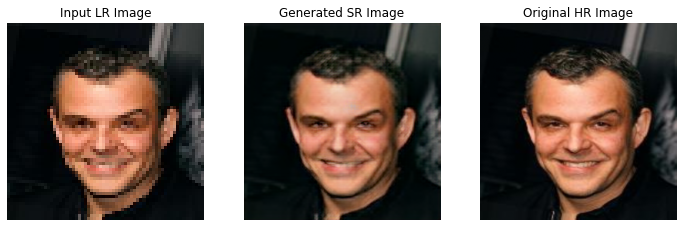

In [5]:
img_lr, img_sr, img_hr = rescale_img('datasets/img_align_celeba/130082.jpg')
plot_image(img_lr, img_sr, img_hr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


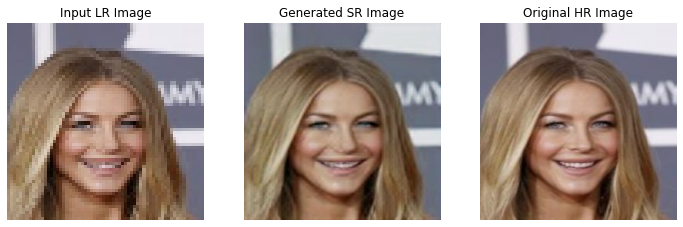

In [6]:
img_lr, img_sr, img_hr = rescale_img('datasets/img_align_celeba/130869.jpg')
plot_image(img_lr, img_sr, img_hr)